Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.1256 - val_loss: 0.0506
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0173 - val_loss: 0.0047
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0133 - val_loss: 0.0228
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0175 - val_loss: 0.0313
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0153 - val_loss: 0.0066
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0115 - val_loss: 0.0045
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0156 - val_loss: 0.0035
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0097 - val_loss: 0.0073
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0097 - val_loss: 0.0038
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0097 - val_loss: 0.0117
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0095 - val_loss: 0.0040
1/1 ━━━━━━━

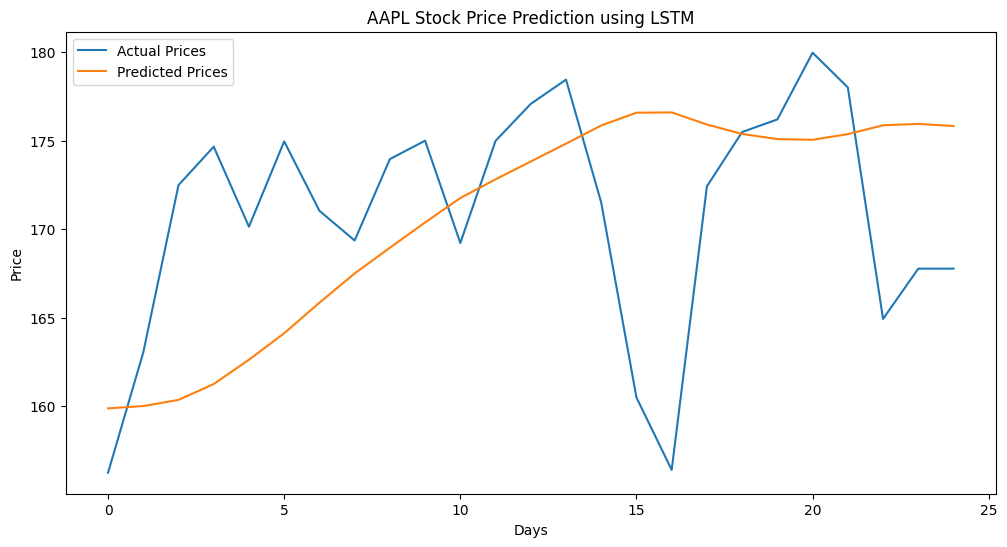

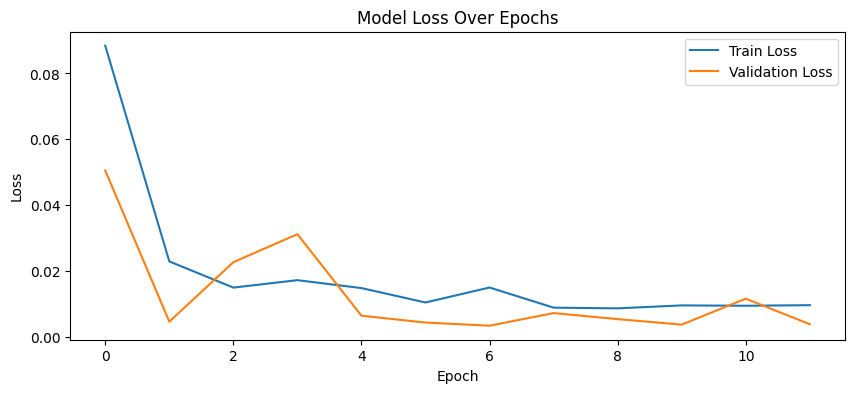

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load the dataset
data = pd.read_csv('/content/AAPL.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

# 2. Preprocess - use only 'Close' prices
close_data = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_data)

# 3. Create sequences for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)

# 4. Split into train and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_split=0.1, callbacks=[early_stop], verbose=1)

# 7. Predict and inverse scale
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

# 8. Evaluation Metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)

print(f"\n LSTM Forecasting Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# 9. Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('AAPL Stock Price Prediction using LSTM')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# 10. Optional: Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
